# SageMaker DeepAR Time Series Forecasting Exercise

This notebook walks you through training Amazon SageMaker's **DeepAR** algorithm on synthetic retail demand data.

## What You'll Learn
1. How to prepare data in DeepAR's required format
2. How to configure and train a DeepAR model
3. How to deploy and query the model for predictions
4. How to evaluate forecast quality

## Prerequisites
- SageMaker notebook instance or Studio
- IAM role with S3 and SageMaker permissions

---

## Step 1: Setup and Imports

In [ ]:
# Install required packages (if needed)
# !pip install -q matplotlib pandas numpy sagemaker boto3

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure AWS session from environment variables
aws_profile = os.getenv('AWS_PROFILE')
aws_region = os.getenv('AWS_REGION', 'us-west-2')
sagemaker_role = os.getenv('SAGEMAKER_ROLE_ARN')

if aws_profile:
    boto3.setup_default_session(profile_name=aws_profile, region_name=aws_region)
else:
    boto3.setup_default_session(region_name=aws_region)

# SageMaker session and role
sagemaker_session = sagemaker.Session()

# Use environment variable for role, or fall back to execution role if running in SageMaker
if sagemaker_role:
    role = sagemaker_role
else:
    role = get_execution_role()

region = sagemaker_session.boto_region_name

print(f"AWS Profile: {aws_profile or 'default'}")
print(f"SageMaker Role: {role}")
print(f"Region: {region}")
print(f"SageMaker SDK Version: {sagemaker.__version__}")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/david.jarmoluk/Library/Application Support/sagemaker/config.yaml
AWS Profile: brightech-secondary
SageMaker Role: arn:aws:iam::096816224238:role/service-role/AmazonSageMaker-ExecutionRole-20251113T125927
Region: us-west-2
SageMaker SDK Version: 2.255.0


In [2]:
# Configuration - MODIFY THESE FOR YOUR ENVIRONMENT
BUCKET_NAME = sagemaker_session.default_bucket()  # Or specify your bucket
PREFIX = "deep_ar"

# DeepAR hyperparameters
PREDICTION_LENGTH = 30  # Forecast 30 days ahead
CONTEXT_LENGTH = 60     # Use 60 days of history for context
NUM_TIME_SERIES = 50    # Number of products/series

print(f"S3 Bucket: {BUCKET_NAME}")
print(f"S3 Prefix: {PREFIX}")

S3 Bucket: sagemaker-us-west-2-096816224238
S3 Prefix: deep_ar


## Step 2: Generate Synthetic Data

We'll create realistic retail demand data with:
- Multiple product categories
- Weekly seasonality (higher weekend sales)
- Yearly seasonality (holiday peaks)
- Trend components
- Promotional effects (dynamic features)

In [3]:
def generate_single_time_series(
    start_date,
    num_days,
    base_demand,
    trend_slope,
    weekly_pattern,
    yearly_amplitude,
    noise_level,
    seed=None
):
    """
    Generate a single realistic time series.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dates = [start_date + timedelta(days=i) for i in range(num_days)]
    
    # Trend component
    trend = np.array([base_demand + trend_slope * i for i in range(num_days)])
    
    # Weekly seasonality (day of week effect)
    weekly = np.array([weekly_pattern[d.weekday()] for d in dates])
    
    # Yearly seasonality
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    yearly = yearly_amplitude * (
        np.sin(2 * np.pi * (day_of_year - 350) / 365) * 0.7 +
        np.sin(2 * np.pi * (day_of_year - 180) / 365) * 0.3
    )
    
    # Random promotions (~10% of days)
    promotions = (np.random.random(num_days) < 0.10).astype(float)
    promotion_effect = promotions * base_demand * 0.3
    
    # Noise
    noise = np.random.normal(0, noise_level * base_demand, num_days)
    
    # Combine
    demand = trend + weekly + yearly + promotion_effect + noise
    demand = np.maximum(demand, 0)
    demand = np.round(demand).astype(int)
    
    return demand, promotions

In [4]:
def generate_dataset(num_series=50, num_days=730, prediction_length=30):
    """
    Generate complete dataset for DeepAR.
    
    Creates three datasets:
    - train_data: For training (target excludes last prediction_length days)
    - test_data: For training validation (full target, used by SageMaker during training)
    - inference_data: For batch inference (target=history only, dynamic_feat=history+forecast)
    
    IMPORTANT: For inference with dynamic features, DeepAR requires:
    - target: historical values only (what you know)
    - dynamic_feat: must cover target length PLUS prediction_length
    """
    start = datetime(2022, 1, 1)
    
    # Product categories with different characteristics
    categories = [
        {"name": "electronics", "base_range": (100, 500), "trend": (0.05, 0.15), "noise": 0.15},
        {"name": "clothing", "base_range": (200, 800), "trend": (-0.02, 0.08), "noise": 0.20},
        {"name": "groceries", "base_range": (500, 2000), "trend": (0.01, 0.05), "noise": 0.10},
        {"name": "home_garden", "base_range": (50, 300), "trend": (0.02, 0.10), "noise": 0.25},
        {"name": "toys", "base_range": (80, 400), "trend": (0.0, 0.12), "noise": 0.30},
    ]
    
    weekly_patterns = {
        "electronics": np.array([1.0, 0.9, 0.85, 0.9, 1.1, 1.4, 1.3]) * 50,
        "clothing": np.array([0.8, 0.7, 0.75, 0.9, 1.2, 1.5, 1.4]) * 80,
        "groceries": np.array([1.1, 0.9, 0.85, 0.9, 1.0, 1.3, 1.2]) * 100,
        "home_garden": np.array([0.7, 0.6, 0.65, 0.7, 0.9, 1.5, 1.6]) * 40,
        "toys": np.array([0.9, 0.8, 0.8, 0.85, 1.0, 1.4, 1.5]) * 60,
    }
    
    train_data = []
    test_data = []
    inference_data = []
    all_series = []
    
    for i in range(num_series):
        cat = categories[i % len(categories)]
        cat_name = cat["name"]
        
        base_demand = np.random.uniform(*cat["base_range"])
        trend_slope = np.random.uniform(*cat["trend"])
        yearly_amplitude = base_demand * np.random.uniform(0.15, 0.30)  # 15-30% of base demand
        
        target, promotions = generate_single_time_series(
            start_date=start,
            num_days=num_days,
            base_demand=base_demand,
            trend_slope=trend_slope,
            weekly_pattern=weekly_patterns[cat_name],
            yearly_amplitude=yearly_amplitude,
            noise_level=cat["noise"],
            seed=i * 42
        )
        
        # Store raw data for visualization
        all_series.append({
            "id": f"product_{i:04d}",
            "category": cat_name,
            "target": target,
            "promotions": promotions
        })
        
        # DeepAR format - Training (target excludes last prediction_length days)
        # dynamic_feat matches target length
        train_entry = {
            "start": start.strftime("%Y-%m-%d %H:%M:%S"),
            "target": target[:-prediction_length].tolist(),
            "cat": [i % len(categories)],
            "dynamic_feat": [promotions[:-prediction_length].tolist()]
        }
        
        # DeepAR format - Test/Validation during training (full series for both)
        # SageMaker uses this to calculate validation metrics during training
        test_entry = {
            "start": start.strftime("%Y-%m-%d %H:%M:%S"),
            "target": target.tolist(),
            "cat": [i % len(categories)],
            "dynamic_feat": [promotions.tolist()]
        }
        
        # DeepAR format - Inference (for batch transform)
        # target = history only (700 days - what we know)
        # dynamic_feat = history + forecast period (730 days - must extend prediction_length beyond target)
        inference_entry = {
            "start": start.strftime("%Y-%m-%d %H:%M:%S"),
            "target": target[:-prediction_length].tolist(),
            "cat": [i % len(categories)],
            "dynamic_feat": [promotions.tolist()]
        }
        
        train_data.append(train_entry)
        test_data.append(test_entry)
        inference_data.append(inference_entry)
    
    return train_data, test_data, inference_data, all_series, categories

In [5]:
# Generate the data
print("Generating synthetic time series data...")
train_data, test_data, inference_data, all_series, categories = generate_dataset(
    num_series=NUM_TIME_SERIES,
    num_days=730,  # 2 years
    prediction_length=PREDICTION_LENGTH
)

print(f"\nGenerated {len(train_data)} time series")
print(f"Training series length: {len(train_data[0]['target'])} days")
print(f"Test series length: {len(test_data[0]['target'])} days")
print(f"Prediction horizon: {PREDICTION_LENGTH} days")
print(f"Categories: {[c['name'] for c in categories]}")

# Show inference data structure (key for understanding dynamic_feat requirements)
print(f"\nInference data structure:")
print(f"  target length: {len(inference_data[0]['target'])} days (history only)")
print(f"  dynamic_feat length: {len(inference_data[0]['dynamic_feat'][0])} days (history + forecast)")

Generating synthetic time series data...

Generated 50 time series
Training series length: 700 days
Test series length: 730 days
Prediction horizon: 30 days
Categories: ['electronics', 'clothing', 'groceries', 'home_garden', 'toys']

Inference data structure:
  target length: 700 days (history only)
  dynamic_feat length: 730 days (history + forecast)


## Step 3: Visualize the Data

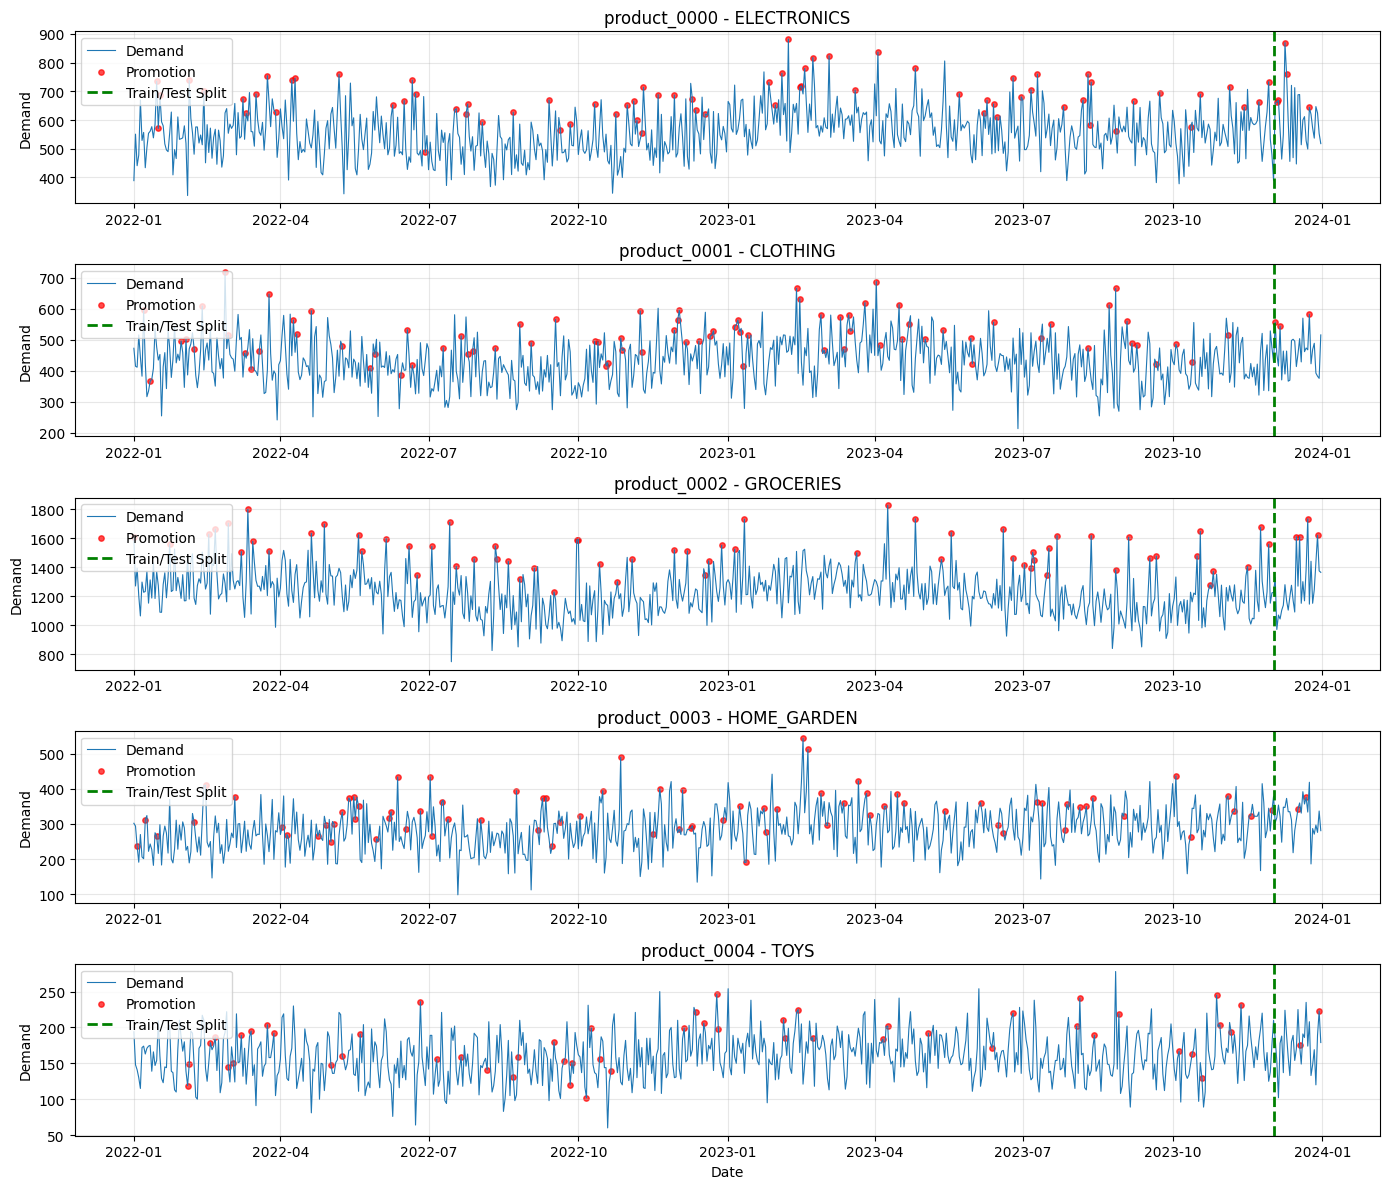


Note: Green dashed line shows train/test split
Red dots indicate promotion days (dynamic feature)


In [6]:
# Visualize sample time series from each category
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

start_date = datetime(2022, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(730)]

for idx, cat in enumerate(categories):
    # Find first series in this category
    series = all_series[idx]
    ax = axes[idx]
    
    ax.plot(dates, series['target'], linewidth=0.8, label='Demand')
    
    # Mark promotion days
    promo_indices = np.where(series['promotions'] == 1)[0]
    promo_dates = [dates[i] for i in promo_indices]
    promo_values = [series['target'][i] for i in promo_indices]
    ax.scatter(promo_dates, promo_values, color='red', s=15, alpha=0.7, label='Promotion')
    
    # Mark train/test split
    split_date = dates[-PREDICTION_LENGTH]
    ax.axvline(x=split_date, color='green', linestyle='--', linewidth=2, label='Train/Test Split')
    
    ax.set_title(f"{series['id']} - {series['category'].upper()}")
    ax.set_ylabel('Demand')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

print("\nNote: Green dashed line shows train/test split")
print("Red dots indicate promotion days (dynamic feature)")

## Step 4: Save Data in DeepAR Format and Upload to S3

DeepAR requires data in JSON Lines format where each line is a JSON object representing one time series.

In [7]:
# Create local data directory
os.makedirs('data', exist_ok=True)

# Save training data (JSON Lines format)
with open('data/train.json', 'w') as f:
    for entry in train_data:
        f.write(json.dumps(entry) + '\n')

# Save test data (used during training for validation)
with open('data/test.json', 'w') as f:
    for entry in test_data:
        f.write(json.dumps(entry) + '\n')

# Save inference data (for batch transform - has extended dynamic_feat for forecast period)
with open('data/inference.json', 'w') as f:
    for entry in inference_data:
        f.write(json.dumps(entry) + '\n')

print("Data saved locally in JSON Lines format")
print(f"  - data/train.json ({os.path.getsize('data/train.json') / 1024:.1f} KB)")
print(f"  - data/test.json ({os.path.getsize('data/test.json') / 1024:.1f} KB)")
print(f"  - data/inference.json ({os.path.getsize('data/inference.json') / 1024:.1f} KB)")

Data saved locally in JSON Lines format
  - data/train.json (351.7 KB)
  - data/test.json (366.6 KB)
  - data/inference.json (359.0 KB)


In [10]:
# Examine the data format
print("Sample training entry (first time series):")
print("="*50)
sample = train_data[0].copy()
sample['target'] = f"[{sample['target'][0]}, {sample['target'][1]}, ... {sample['target'][-1]}] (length: {len(train_data[0]['target'])})"
sample['dynamic_feat'] = f"[[{train_data[0]['dynamic_feat'][0][0]}, ... {train_data[0]['dynamic_feat'][0][-1]}]] (length: {len(train_data[0]['dynamic_feat'][0])})"
print(json.dumps(sample, indent=2))

Sample training entry (first time series):
{
  "start": "2022-01-01 00:00:00",
  "target": "[140, 172, ... 185] (length: 700)",
  "cat": [
    0
  ],
  "dynamic_feat": "[[0.0, ... 0.0]] (length: 700)"
}


In [11]:
# Upload to S3
s3_client = boto3.client('s3')

train_s3_path = f"{PREFIX}/train/train.json"
test_s3_path = f"{PREFIX}/test/test.json"
inference_s3_path = f"{PREFIX}/inference/inference.json"

s3_client.upload_file('data/train.json', BUCKET_NAME, train_s3_path)
s3_client.upload_file('data/test.json', BUCKET_NAME, test_s3_path)
s3_client.upload_file('data/inference.json', BUCKET_NAME, inference_s3_path)

train_s3_uri = f"s3://{BUCKET_NAME}/{train_s3_path}"
test_s3_uri = f"s3://{BUCKET_NAME}/{test_s3_path}"
inference_s3_uri = f"s3://{BUCKET_NAME}/{inference_s3_path}"

print("Data uploaded to S3:")
print(f"  Train: {train_s3_uri}")
print(f"  Test:  {test_s3_uri}")
print(f"  Inference: {inference_s3_uri}")

Data uploaded to S3:
  Train: s3://sagemaker-us-west-2-096816224238/deep_ar/train/train.json
  Test:  s3://sagemaker-us-west-2-096816224238/deep_ar/test/test.json
  Inference: s3://sagemaker-us-west-2-096816224238/deep_ar/inference/inference.json


## Step 5: Configure and Train the DeepAR Model

### Key Hyperparameters

**prediction_length** (Required)
- Number of time steps to forecast into the future
- Must match the forecast horizon you need (e.g., 30 for monthly forecasts with daily data)
- Longer prediction lengths are harder to forecast accurately
- Cannot be changed after training—you must retrain for a different horizon

**context_length**
- How many historical time steps the model looks at when making each prediction
- Acts as a "sliding window" of history the model uses to understand patterns
- Rule of thumb: set to 2-3x the prediction_length to capture relevant seasonality
- Too short: model misses seasonal patterns; Too long: slower training, potential noise

**epochs**
- Number of complete passes through the training data
- More epochs = more learning, but risk of overfitting
- Use with `early_stopping_patience` to stop when validation loss stops improving
- Typical range: 50-500 depending on dataset size

**num_cells**
- Number of neurons (hidden units) in each LSTM layer
- DeepAR uses an encoder-decoder architecture with stacked LSTM layers. Each layer is a full recurrent neural network with this many hidden units. The term "RNN" here refers to a single recurrent layer within the larger stacked architecture
- Controls model capacity—larger values can capture more complex temporal patterns
- These neurons maintain hidden states that carry information across time steps
- Too large: overfitting, slower training; Too small: underfitting
- Typical range: 30-100

**num_layers**
- Number of stacked LSTM layers (depth of the network)
- With `num_layers=2` and `num_cells=40`, you have 2 LSTM layers stacked sequentially, each with 40 neurons
- Deeper networks can learn hierarchical patterns (e.g., short-term fluctuations in early layers, longer seasonal patterns in later layers)
- More layers = more capacity but harder to train and risk of vanishing gradients
- Typical values: 1-3 (2 is usually a good default)

**dropout_rate**
- Regularization technique to prevent overfitting
- During training, randomly "drops" (sets to zero) this fraction of neurons at each forward pass
- A rate of 0.05 means 5% of neurons are randomly disabled during each training step
- Forces the network to learn redundant representations and not rely too heavily on any single neuron
- Only active during training—at inference time, all neurons are used (with scaled weights)
- Too high: underfitting (model can't learn enough); Too low: less regularization benefit
- Typical range: 0.0-0.3 (0.05-0.1 is a good starting point)

**cardinality**
- The number of unique values in each categorical feature (`cat` field)
- In this notebook, we have 5 product categories (electronics, clothing, groceries, home_garden, toys), so cardinality = 5
- DeepAR creates a learned embedding vector for each category value, allowing the model to:
  - Share statistical strength across related time series
  - Learn category-specific patterns (e.g., toys have higher holiday seasonality)
  - Distinguish between fundamentally different demand behaviors
- Set to `"auto"` to let SageMaker detect cardinality from the data, or specify as a list (e.g., `"[5]"` for one categorical feature with 5 values, `"[5, 10]"` for two features)
- If you have multiple `cat` features, provide cardinality for each in order

**likelihood**
- The probability distribution used to model the target variable
- `negative-binomial`: Best for count data (units sold, visitors, etc.)—handles overdispersion where variance exceeds mean
- `gaussian`: For continuous data that can be negative
- `student-t`: Like gaussian but more robust to outliers

In [12]:
# DeepAR hyperparameters
PREDICTION_LENGTH = 30  # Forecast 30 days ahead
CONTEXT_LENGTH = 60     # Use 60 days of history for context
NUM_TIME_SERIES = 50    # Number of products/series

# Get the DeepAR container image
from sagemaker.image_uris import retrieve

deepar_image = retrieve(
    framework='forecasting-deepar',
    region=region,
    version='latest'
)

print(f"DeepAR Image URI: {deepar_image}")

DeepAR Image URI: 156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:1


In [13]:
# Define the estimator
from sagemaker.estimator import Estimator

deepar_estimator = Estimator(
    image_uri=deepar_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',  # Cost-effective for this exercise
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/output',
    sagemaker_session=sagemaker_session,
    base_job_name='deepar-demand-forecast'
)

In [14]:
# Set hyperparameters
hyperparameters = {
    # Required parameters
    "time_freq": "D",                    # Daily frequency
    "prediction_length": PREDICTION_LENGTH,
    "context_length": CONTEXT_LENGTH,    # 2x prediction_length is a good starting point
    
    # Data parameters
    "num_dynamic_feat": 1,               # We have 1 dynamic feature (promotions)
    "cardinality": "auto",               # Auto-detect category cardinality
    
    # Model architecture
    "num_cells": 40,                     # RNN hidden size
    "num_layers": 2,                     # Number of RNN layers
    "dropout_rate": 0.05,                # Regularization
    
    # Training parameters
    "epochs": 100,                       # Training epochs
    "mini_batch_size": 32,               # Batch size
    "learning_rate": 0.001,              # Learning rate
    "early_stopping_patience": 10,       # Stop if no improvement for 10 epochs
    
    # Likelihood (use negative binomial for count data)
    "likelihood": "negative-binomial",
}

deepar_estimator.set_hyperparameters(**hyperparameters)

print("Hyperparameters configured:")
for k, v in hyperparameters.items():
    print(f"  {k}: {v}")

Hyperparameters configured:
  time_freq: D
  prediction_length: 30
  context_length: 60
  num_dynamic_feat: 1
  cardinality: auto
  num_cells: 40
  num_layers: 2
  dropout_rate: 0.05
  epochs: 100
  mini_batch_size: 32
  learning_rate: 0.001
  early_stopping_patience: 10
  likelihood: negative-binomial


In [15]:
# Define data channels
data_channels = {
    "train": train_s3_uri,
    "test": test_s3_uri
}

print("Starting training job...")
print("This will take approximately 5-10 minutes.\n")

# Start training
deepar_estimator.fit(inputs=data_channels, wait=True, logs=True)

INFO:sagemaker:Creating training-job with name: deepar-demand-forecast-2025-12-10-15-52-55-545


Starting training job...
This will take approximately 5-10 minutes.

2025-12-10 15:52:57 Starting - Starting the training job...
2025-12-10 15:53:32 Downloading - Downloading input data......
2025-12-10 15:54:13 Downloading - Downloading the training image...........Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.9/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/10/2025 15:56:15 INFO 139997516052288] Reading default configuration from /opt/amazon/lib/python3.9/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_

## Step 6: Run Batch Transform

In [16]:
# Create transformer from the trained model
transformer = deepar_estimator.transformer(
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{BUCKET_NAME}/{PREFIX}/batch-predictions'
)

# Run batch inference on INFERENCE data (not test data!)
# inference_data has: target=700 days, dynamic_feat=730 days
# This allows DeepAR to forecast 30 days using the extended dynamic features
transformer.transform(
    data=inference_s3_uri,
    content_type='application/jsonlines',
    split_type='Line',
    wait=True
)

print(f"Predictions written to: {transformer.output_path}")

INFO:sagemaker:Creating model with name: deepar-demand-forecast-2025-12-10-15-58-06-583
INFO:sagemaker:Creating transform job with name: deepar-demand-forecast-2025-12-10-15-58-07-443


.....................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.9/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Failed to set debug level to 20, using INFO
[12/10/2025 16:04:37 INFO 140337336821568] Estimated memory required per model 23.840975761413574MB.
[12/10/2025 16:04:37 INFO 140337336821568] Estimated available memory 6696.056329727173MB.
[12/10/2025 16:04:37 INFO 140337336821568] Estimated maximum number of workers for the available memory is 280.
[12/10/2025 16:04:37 INFO 140337336821568] Using 2 workers
[12/10/2025 16:04:37 INFO 140337336821568] loading entry points
[12/10/2025 16:04:37 INFO 140337336821568] Prediction endpoint operating in batch mode
[12/10/2025 16:04:37 INFO 140337336821568] loaded request iterator application/jsonlines
[12/10/2

## Step 7: Download and Parse Predictions

In [18]:
import boto3
import json
import re

# Download predictions from S3
s3 = boto3.client('s3')
prediction_key = f"{PREFIX}/batch-predictions/inference.json.out"

response = s3.get_object(Bucket=BUCKET_NAME, Key=prediction_key)
predictions_raw = response['Body'].read().decode('utf-8')

# Parse predictions - handle both newline-delimited and concatenated JSON
predictions = []

# First try splitting by newlines
lines = predictions_raw.strip().split('\n')

for line in lines:
    line = line.strip()
    if not line:
        continue

    # If the line contains multiple JSON objects concatenated (no separator),
    # we need to parse them individually using a regex to find JSON boundaries
    try:
        # Try parsing the whole line as a single JSON object
        predictions.append(json.loads(line))
    except json.JSONDecodeError:
        # Multiple JSON objects on the same line - parse them one by one
        # Find all JSON objects by matching balanced braces
        decoder = json.JSONDecoder()
        idx = 0
        while idx < len(line):
            # Skip whitespace
            while idx < len(line) and line[idx].isspace():
                idx += 1
            if idx >= len(line):
                break
            try:
                obj, end_idx = decoder.raw_decode(line, idx)
                predictions.append(obj)
                idx = end_idx
            except json.JSONDecodeError:
                break

print(f"Loaded predictions for {len(predictions)} time series")

Loaded predictions for 50 time series


## Step 8: Compare Predictions vs Actuals

### Understanding the Evaluation Metrics

**MAE (Mean Absolute Error)**
- Average absolute difference between predicted and actual values, in the same units as your data
- Example: MAE of 50 means predictions are off by 50 units on average
- **Interpretation**: Lower is better. Compare to the scale of your data:
    - If average demand is 500 units, MAE of 50 = 10% error (good)
    - If average demand is 100 units, MAE of 50 = 50% error (poor)

**RMSE (Root Mean Square Error)**
- Like MAE, but penalizes large errors more heavily (squares errors before averaging)
- Always ≥ MAE; the gap indicates how many large errors exist
- **Interpretation**:
    - RMSE close to MAE → errors are consistent (few outliers)
    - RMSE much larger than MAE → some predictions have large errors

**MAPE (Mean Absolute Percentage Error)**
- Error as a percentage of actual values—scale-independent
- **Interpretation benchmarks for demand forecasting**:
    - < 10%: Excellent (typically only achievable with stable, predictable series)
    - 10-20%: Good (reasonable for most retail forecasting)
    - 20-30%: Acceptable (common for products with high variability)
    - 30-50%: Needs improvement (consider adding features or more data)
    - \> 50%: Poor (model may not be capturing key patterns)

### Context for This Exercise

Our synthetic data has intentional noise (10-30% depending on category), so expect:
- **Groceries** (10% noise): Best performance, MAPE likely 10-15%
- **Electronics** (15% noise): Good performance, MAPE likely 12-18%
- **Clothing** (20% noise): Moderate performance, MAPE likely 15-25%
- **Home & Garden** (25% noise): Higher variability, MAPE likely 18-30%
- **Toys** (30% noise): Highest variability, MAPE likely 20-35%

A well-tuned model should have MAPE roughly in the range of the underlying noise level—you can't 
predict noise!

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(actual, predicted_p50, predicted_p10=None, predicted_p90=None):
    """Calculate forecast accuracy metrics."""
    actual = np.array(actual)
    predicted = np.array(predicted_p50)

    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))

    # MAPE (avoid division by zero)
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

    # Also return mean actual for context
    mean_actual = np.mean(actual)

    # Calculate coverage (% of actuals within P10-P90 CI)
    coverage = None
    if predicted_p10 is not None and predicted_p90 is not None:
        p10 = np.array(predicted_p10)
        p90 = np.array(predicted_p90)
        within_ci = (actual >= p10) & (actual <= p90)
        coverage = np.mean(within_ci) * 100

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'mean_actual': mean_actual, 'coverage': coverage}

# Evaluate each series
results = []
for i, pred in enumerate(predictions):
    # Actual values: last 30 days from test data
    actual = test_data[i]['target'][-PREDICTION_LENGTH:]

    # Predicted values
    predicted_p50 = pred['quantiles']['0.5']
    predicted_p10 = pred['quantiles']['0.1']
    predicted_p90 = pred['quantiles']['0.9']

    metrics = calculate_metrics(actual, predicted_p50, predicted_p10, predicted_p90)
    metrics['series'] = i
    metrics['category'] = all_series[i]['category']
    results.append(metrics)

# Summary by category
print("=" * 80)
print("MODEL EVALUATION RESULTS BY CATEGORY")
print("=" * 80)

category_results = {}
for cat in ['electronics', 'clothing', 'groceries', 'home_garden', 'toys']:
    cat_metrics = [r for r in results if r['category'] == cat]
    if cat_metrics:
        category_results[cat] = {
            'MAE': np.mean([r['MAE'] for r in cat_metrics]),
            'RMSE': np.mean([r['RMSE'] for r in cat_metrics]),
            'MAPE': np.mean([r['MAPE'] for r in cat_metrics]),
            'mean_demand': np.mean([r['mean_actual'] for r in cat_metrics]),
            'coverage': np.mean([r['coverage'] for r in cat_metrics]),
            'count': len(cat_metrics)
        }

# Print header
print(f"\n{'Category':<12} {'Avg Demand':>10} {'MAE':>10} {'MAE %':>8} {'RMSE':>10} {'MAPE':>8} {'Coverage':>10}")
print("-" * 80)

for cat, metrics in category_results.items():
    mae_pct = (metrics['MAE'] / metrics['mean_demand']) * 100
    print(f"{cat:<12} {metrics['mean_demand']:>10.0f} {metrics['MAE']:>10.1f} {mae_pct:>7.1f}% {metrics['RMSE']:>10.1f} {metrics['MAPE']:>7.1f}% {metrics['coverage']:>9.1f}%")

# Overall summary
print("-" * 80)
avg_mae = np.mean([r['MAE'] for r in results])
avg_rmse = np.mean([r['RMSE'] for r in results])
avg_mape = np.mean([r['MAPE'] for r in results])
avg_demand = np.mean([r['mean_actual'] for r in results])
avg_mae_pct = (avg_mae / avg_demand) * 100
avg_coverage = np.mean([r['coverage'] for r in results])

print(f"{'OVERALL':<12} {avg_demand:>10.0f} {avg_mae:>10.1f} {avg_mae_pct:>7.1f}% {avg_rmse:>10.1f} {avg_mape:>7.1f}% {avg_coverage:>9.1f}%")

# Interpretation guide
rmse_mae_ratio = avg_rmse / avg_mae
print(f"""
{'=' * 80}
INTERPRETATION GUIDE
{'=' * 80}

Metrics Explained:
  Avg Demand: Mean daily demand for this category (units)
  MAE:        Mean Absolute Error - average prediction error in units
  MAE %:      MAE as percentage of average demand (normalized MAE)
  RMSE:       Root Mean Square Error - like MAE but penalizes large errors
  MAPE:       Mean Absolute Percentage Error - error relative to each actual value
  Coverage:   % of actual values that fell within the 80% CI (P10-P90)

RMSE vs MAE ratio: {rmse_mae_ratio:.2f} (closer to 1.0 = consistent errors, >1.5 = some large outlier errors)

Quality Assessment:
  MAE % or MAPE < 15%:  Good - model captures main patterns
  MAE % or MAPE 15-25%: Acceptable - room for improvement
  MAE % or MAPE > 25%:  Needs work - check for missing features or data issues

Coverage Assessment (for 80% CI, expect ~80%):
  Coverage ~ 80%:  Well-calibrated - uncertainty estimates are reliable
  Coverage < 80%:  Overconfident - CI too narrow, model underestimates uncertainty
  Coverage > 80%:  Underconfident - CI too wide, model overestimates uncertainty
""")

MODEL EVALUATION RESULTS BY CATEGORY

Category     Avg Demand        MAE    MAE %       RMSE     MAPE   Coverage
--------------------------------------------------------------------------------
electronics         444       53.2    12.0%       65.0    10.7%      81.0%
clothing            525       75.5    14.4%       92.5    14.2%      74.3%
groceries          1483      161.1    10.9%      207.4    10.3%      89.7%
home_garden         285       46.7    16.4%       57.8    16.0%      64.7%
toys                312       54.6    17.5%       69.7    16.7%      64.7%
--------------------------------------------------------------------------------
OVERALL             610       78.2    12.8%       98.5    13.6%      74.9%

INTERPRETATION GUIDE

Metrics Explained:
  Avg Demand: Mean daily demand for this category (units)
  MAE:        Mean Absolute Error - average prediction error in units
  MAE %:      MAE as percentage of average demand (normalized MAE)
  RMSE:       Root Mean Square Error -

## Step 9: Visualize a Few Series

### Understanding the Prediction Intervals

DeepAR provides **probabilistic forecasts**, not just single point predictions. The chart shows:

- **Green line (Actual)**: The real values we're trying to predict
- **Red dashed line (P50)**: The median prediction—50% chance actual is above, 50% below
- **Red shaded area (80% CI)**: The confidence interval between P10 and P90

**What is the 80% Confidence Interval?**

The shaded region spans from the 10th percentile (P10) to the 90th percentile (P90):
- **P10**: Model believes there's only a 10% chance the actual will be *below* this value
- **P90**: Model believes there's only a 10% chance the actual will be *above* this value
- **80% CI**: The range where 80% of actual values should fall (90% - 10% = 80%)

**How to interpret it:**
- **Narrow CI** → Model is confident (low uncertainty)
- **Wide CI** → Model is uncertain (high variability or unpredictable patterns)
- **Actuals inside CI** → Model's uncertainty is well-calibrated
- **Many actuals outside CI** → Model may be overconfident or missing key patterns

**Why probabilistic forecasts matter:**

For business decisions, knowing the range of likely outcomes is often more valuable than a single
number:
- Inventory planning: Stock based on P90 to avoid stockouts
- Staffing: Plan for P50, but have contingency for P90
- Budgeting: Use P10 for conservative revenue estimates

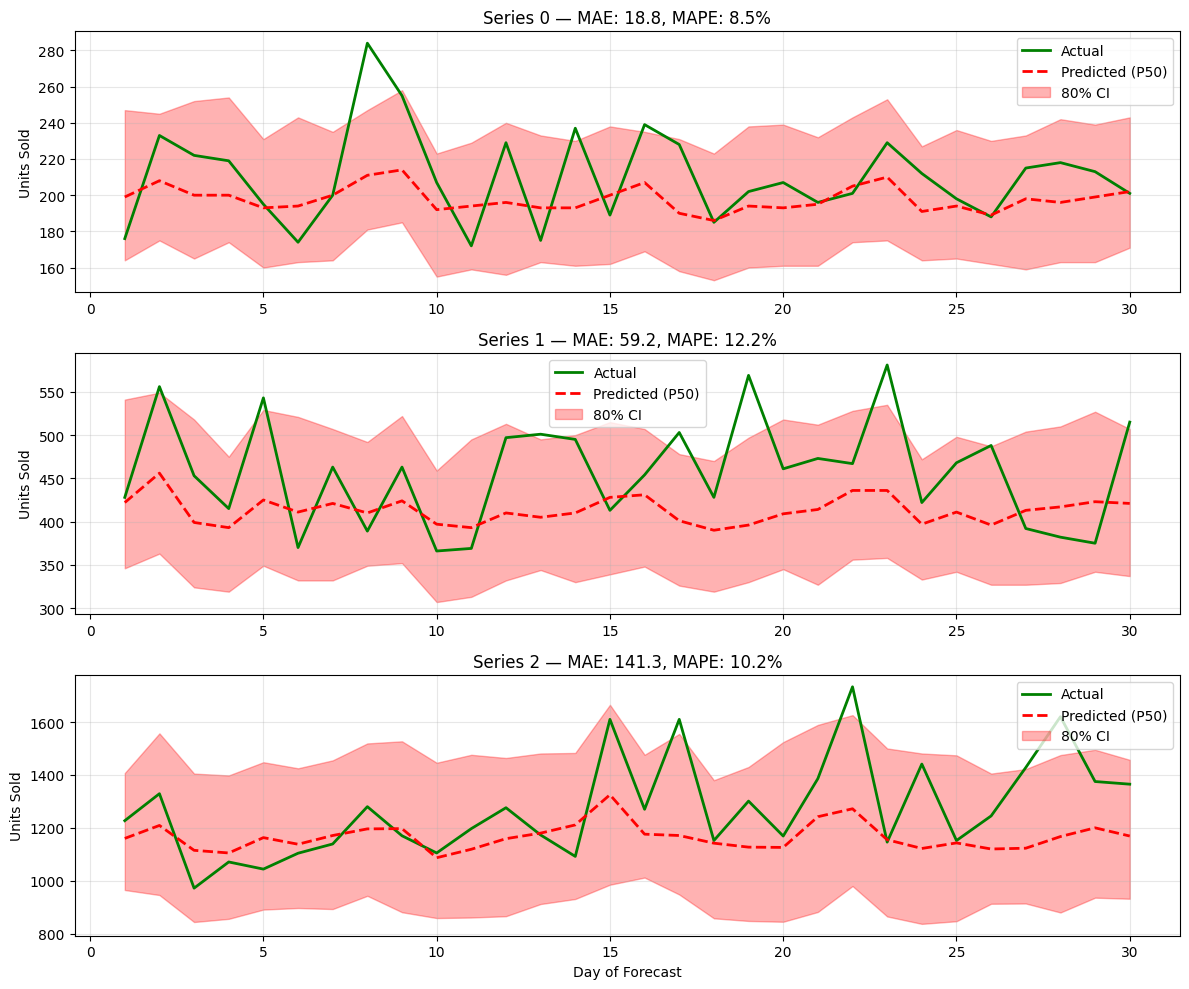

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for idx, ax in enumerate(axes):
    # Actual values (last 30 days)
    actual = test_data[idx]['target'][-PREDICTION_LENGTH:]
    
    # Predictions
    p10 = predictions[idx]['quantiles']['0.1']
    p50 = predictions[idx]['quantiles']['0.5']
    p90 = predictions[idx]['quantiles']['0.9']
    
    days = range(1, PREDICTION_LENGTH + 1)
    
    ax.plot(days, actual, 'g-', linewidth=2, label='Actual')
    ax.plot(days, p50, 'r--', linewidth=2, label='Predicted (P50)')
    ax.fill_between(days, p10, p90, alpha=0.3, color='red', label='80% CI')
    
    ax.set_title(f"Series {idx} — MAE: {results[idx]['MAE']:.1f}, MAPE: {results[idx]['MAPE']:.1f}%")
    ax.set_ylabel('Units Sold')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Day of Forecast')
plt.tight_layout()
plt.show()

In [ ]:
# Get training job info
training_job_name = deepar_estimator.latest_training_job.name
print(f"Training job completed: {training_job_name}")
print(f"Model artifacts: {deepar_estimator.model_data}")

## Step 10: Deploy the Model

You can stop here, or continue to deploy this model to AWS. 

In [22]:
# Deploy to an endpoint
print("Deploying model to endpoint...")
print("This will take approximately 5-7 minutes.\n")

predictor = deepar_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=f'deepar-demand-endpoint-{datetime.now().strftime("%Y%m%d%H%M")}'
)

print(f"\nEndpoint deployed: {predictor.endpoint_name}")

Deploying model to endpoint...
This will take approximately 5-7 minutes.



INFO:sagemaker:Creating model with name: deepar-demand-forecast-2025-12-10-16-16-35-659
INFO:sagemaker:Creating endpoint-config with name deepar-demand-endpoint-202512101116
INFO:sagemaker:Creating endpoint with name deepar-demand-endpoint-202512101116


---------!
Endpoint deployed: deepar-demand-endpoint-202512101116


## Step 11: Make Predictions

DeepAR returns probabilistic forecasts with quantiles (e.g., P10, P50, P90).

In [26]:
# Create a custom serializer for DeepAR
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

class DeepARPredictor:
    def __init__(self, endpoint_name, sagemaker_session):
        self.endpoint_name = endpoint_name
        self.sagemaker_runtime = boto3.client('sagemaker-runtime')
    
    def predict(self, instances, quantiles=['0.1', '0.5', '0.9']):
        """
        Make predictions for multiple time series.
        
        Args:
            instances: List of time series in DeepAR format
            quantiles: Prediction quantiles to return
        """
        configuration = {
            "num_samples": 100,  # Monte Carlo samples
            "output_types": ["quantiles"],
            "quantiles": quantiles
        }
        
        request_data = {
            "instances": instances,
            "configuration": configuration
        }
        
        response = self.sagemaker_runtime.invoke_endpoint(
            EndpointName=self.endpoint_name,
            ContentType='application/json',
            Body=json.dumps(request_data)
        )
        
        return json.loads(response['Body'].read().decode())

# Create predictor
deepar_predictor = DeepARPredictor(predictor.endpoint_name, sagemaker_session)
print("Predictor ready!")

Predictor ready!


In [27]:
# Prepare inference requests
# Use the training data (which excludes the last 30 days) as input
inference_requests = []

for i in range(5):  # Predict for first 5 series
    request = {
        "start": train_data[i]["start"],
        "target": train_data[i]["target"],
        "cat": train_data[i]["cat"],
        "dynamic_feat": [
            # For inference, we need to provide dynamic features for the forecast horizon too
            # Here we use the actual promotion data from the test set
            test_data[i]["dynamic_feat"][0]  # Full series including forecast period
        ]
    }
    inference_requests.append(request)

print(f"Prepared {len(inference_requests)} inference requests")

Prepared 5 inference requests


In [28]:
# Make predictions
print("Making predictions...")
predictions = deepar_predictor.predict(inference_requests)

print(f"\nReceived predictions for {len(predictions['predictions'])} time series")
print(f"Prediction length: {len(predictions['predictions'][0]['quantiles']['0.5'])} days")

Making predictions...

Received predictions for 5 time series
Prediction length: 30 days


## Step 12: Visualize Predictions vs Actuals

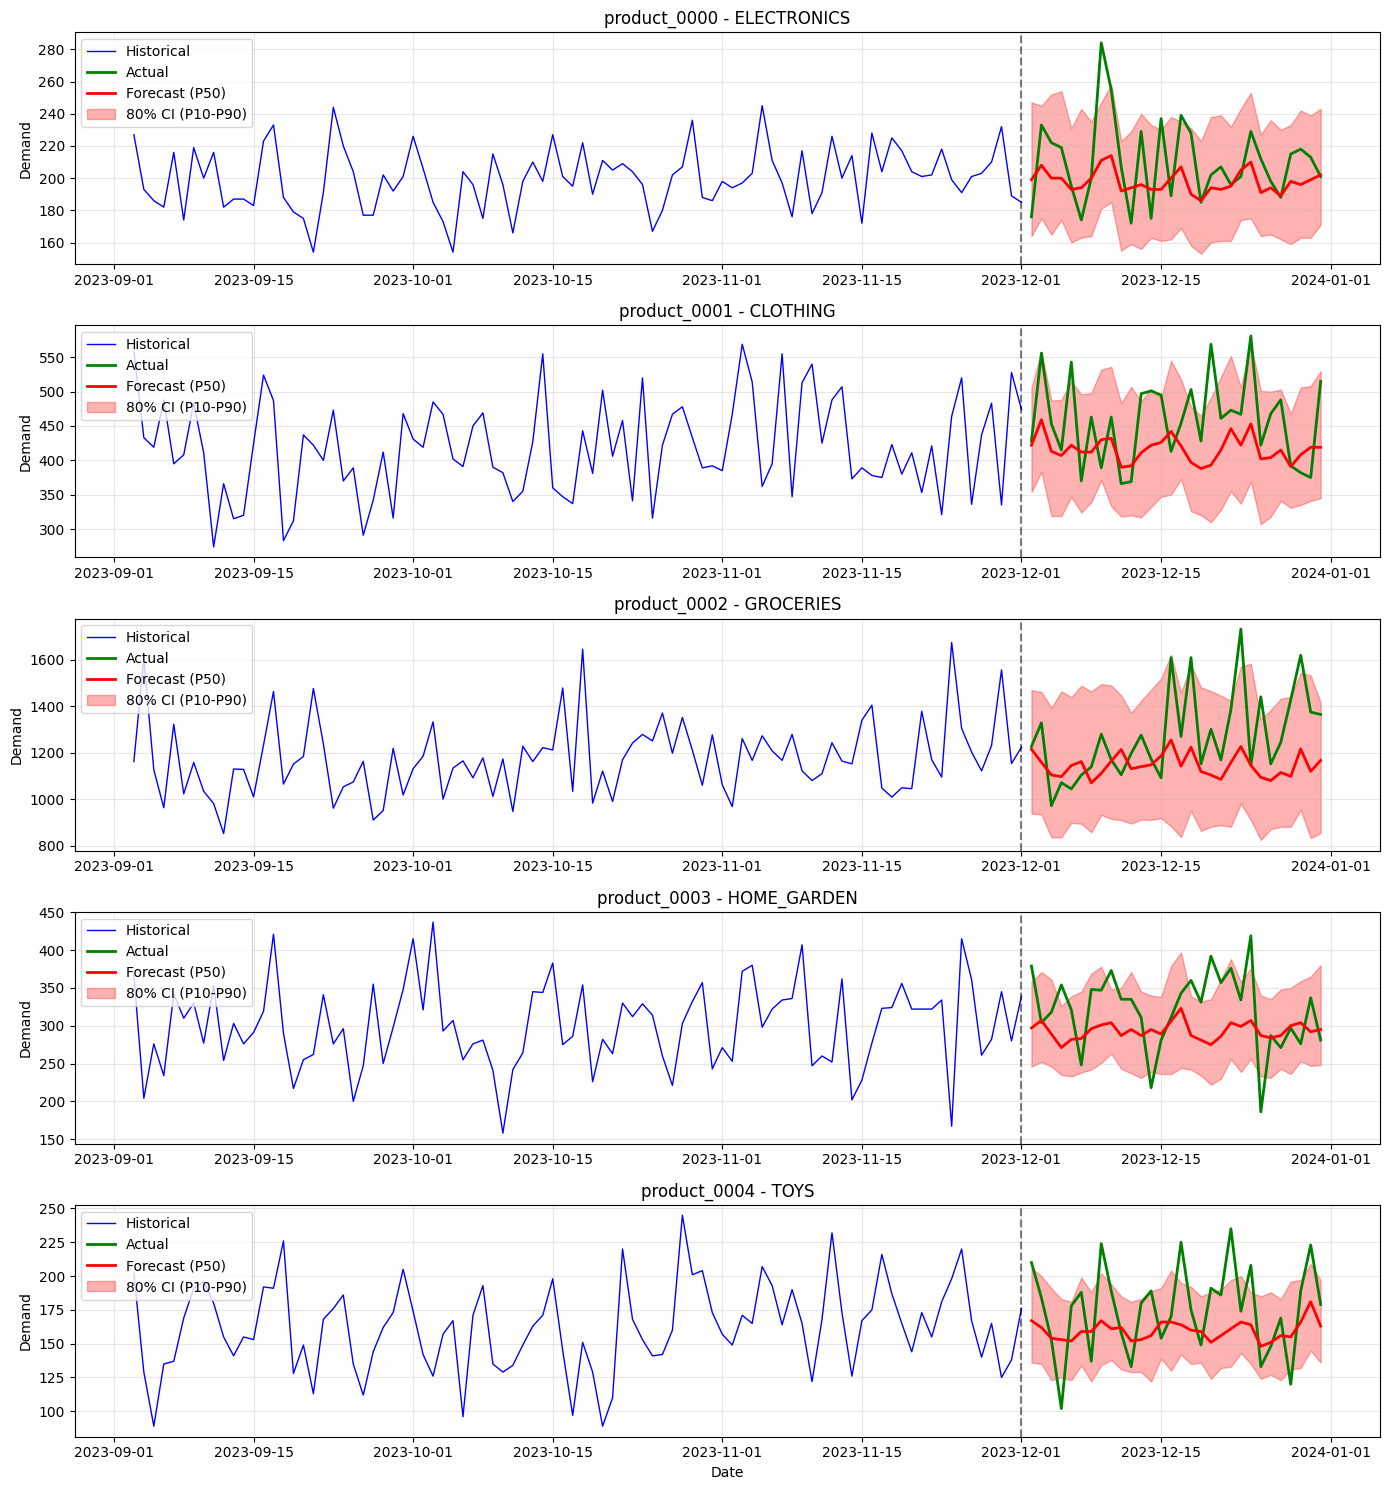

In [29]:
# Plot predictions against actuals
fig, axes = plt.subplots(5, 1, figsize=(14, 15))

start_date = datetime(2022, 1, 1)

for idx in range(5):
    ax = axes[idx]
    series = all_series[idx]
    pred = predictions['predictions'][idx]['quantiles']
    
    # Full time series
    full_dates = [start_date + timedelta(days=i) for i in range(730)]
    
    # Historical data (training period)
    train_length = len(train_data[idx]['target'])
    hist_dates = full_dates[:train_length]
    hist_values = series['target'][:train_length]
    
    # Actual future values
    future_dates = full_dates[train_length:]
    actual_future = series['target'][train_length:]
    
    # Predictions
    p10 = pred['0.1']
    p50 = pred['0.5']
    p90 = pred['0.9']
    
    # Plot historical
    ax.plot(hist_dates[-90:], hist_values[-90:], 'b-', linewidth=1, label='Historical')
    
    # Plot actual future (what we're trying to predict)
    ax.plot(future_dates, actual_future, 'g-', linewidth=2, label='Actual')
    
    # Plot predictions
    ax.plot(future_dates, p50, 'r-', linewidth=2, label='Forecast (P50)')
    ax.fill_between(future_dates, p10, p90, alpha=0.3, color='red', label='80% CI (P10-P90)')
    
    ax.axvline(x=hist_dates[-1], color='black', linestyle='--', alpha=0.5)
    ax.set_title(f"{series['id']} - {series['category'].upper()}")
    ax.set_ylabel('Demand')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

## Step 13: Calculate Evaluation Metrics

In [30]:
def calculate_metrics(actual, predicted_p50):
    """Calculate common forecasting metrics."""
    actual = np.array(actual)
    predicted = np.array(predicted_p50)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(actual - predicted))
    
    # Root Mean Square Error
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    # Mean Absolute Percentage Error (avoid division by zero)
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Calculate metrics for each series
print("Evaluation Metrics:")
print("=" * 60)

all_metrics = []
for idx in range(5):
    actual = all_series[idx]['target'][-PREDICTION_LENGTH:]
    predicted = predictions['predictions'][idx]['quantiles']['0.5']
    
    metrics = calculate_metrics(actual, predicted)
    all_metrics.append(metrics)
    
    print(f"\n{all_series[idx]['id']} ({all_series[idx]['category']}):")
    print(f"  MAE:  {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")

# Overall averages
print("\n" + "=" * 60)
print("AVERAGE METRICS:")
print(f"  MAE:  {np.mean([m['MAE'] for m in all_metrics]):.2f}")
print(f"  RMSE: {np.mean([m['RMSE'] for m in all_metrics]):.2f}")
print(f"  MAPE: {np.mean([m['MAPE'] for m in all_metrics]):.2f}%")

Evaluation Metrics:

product_0000 (electronics):
  MAE:  18.83
  RMSE: 24.58
  MAPE: 8.51%

product_0001 (clothing):
  MAE:  55.73
  RMSE: 68.53
  MAPE: 11.50%

product_0002 (groceries):
  MAE:  160.87
  RMSE: 208.44
  MAPE: 11.67%

product_0003 (home_garden):
  MAE:  46.67
  RMSE: 56.77
  MAPE: 14.67%

product_0004 (toys):
  MAE:  26.90
  RMSE: 32.42
  MAPE: 15.19%

AVERAGE METRICS:
  MAE:  61.80
  RMSE: 78.15
  MAPE: 12.31%


## Step 14: Clean Up Resources

⚠️ **IMPORTANT**: Always delete endpoints when done to avoid ongoing charges!

In [31]:
# Delete the endpoint
print(f"Deleting endpoint: {predictor.endpoint_name}")
predictor.delete_endpoint()
print("Endpoint deleted successfully!")

Deleting endpoint: deepar-demand-endpoint-202512101116


INFO:sagemaker:Deleting endpoint configuration with name: deepar-demand-endpoint-202512101116
INFO:sagemaker:Deleting endpoint with name: deepar-demand-endpoint-202512101116


Endpoint deleted successfully!


In [ ]:
# Optionally, clean up S3 data
# Uncomment the following lines if you want to delete the S3 data

# import boto3
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(BUCKET_NAME)
# bucket.objects.filter(Prefix=PREFIX).delete()
# print(f"Deleted all objects under s3://{BUCKET_NAME}/{PREFIX}")

---

## Summary

In this exercise, you learned:

1. **Data Format**: DeepAR requires JSON Lines format with `start`, `target`, optional `cat` (categories), and optional `dynamic_feat` (time-varying features)

2. **Key Concepts**:
   - **prediction_length**: How far ahead to forecast
   - **context_length**: How much history the model uses
   - **Dynamic features**: Time-varying covariates (like promotions) that must be known for the forecast period

3. **Probabilistic Forecasts**: DeepAR returns quantiles (P10, P50, P90), giving you uncertainty estimates

4. **Best Practices**:
   - Use `negative-binomial` likelihood for count data
   - Set `context_length` to at least 2x `prediction_length`
   - Always clean up endpoints to avoid charges

## Next Steps

- Experiment with different hyperparameters
- Try adding more dynamic features (price, weather, etc.)
- Use hyperparameter tuning to optimize the model
- Try the model on your own time series data